# 🚀 XGBoost Model Analysis

Dieses Notebook analysiert das XGBoost-Modell auf GW2-Preisdaten (sell_unit_price).

**Warum XGBoost statt ARIMA/ES?**
- ✅ Kann komplexe nicht-lineare Muster lernen
- ✅ Verwendet Lag-Features (vergangene Werte als Prädiktoren)
- ✅ Robuster bei volatilen/zufälligen Daten
- ✅ Produziert keine NaN-Forecasts!
- ✅ Schnelleres Backtesting (retrain=False möglich)

**Inhalt:**
1. Daten laden (sell_unit_price)
2. Train/Test Split
3. XGBoost trainieren
4. Forecast vs. Actual
5. Lag-Vergleich
6. Vergleich mit ARIMA/ES


In [2]:
# Imports
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from gw2ml.data import load_gw2_series
from gw2ml.modeling import XGBoostModel, ARIMAModel, ExponentialSmoothingModel

# Plot Style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Farben
COLORS = {
    'train': '#2ecc71',
    'test': '#3498db',
    'xgboost': '#e74c3c',
    'arima': '#f39c12',
    'es': '#9b59b6'
}

# Suppress warnings
warnings.filterwarnings('ignore')


## 1. 📥 Daten laden (sell_unit_price)


In [3]:
# Konfiguration
# ITEM_ID = 19976   # Mystic Coin (volatil!)
# ITEM_ID = 19697   # Copper Ore
ITEM_ID = 19702 # Platinum Ore
DAYS_BACK = 14    # 14 Tage Daten
TRAIN_RATIO = 0.8

# Daten laden mit sell_unit_price
data = load_gw2_series(
    ITEM_ID, 
    days_back=DAYS_BACK,
    value_column="sell_unit_price"  # Verkaufspreis!
)
print(data.info())


GW2Series(Platinum Ore)
  Item ID: 19702
  Period: 2025-12-15 16:25 to 2025-12-29 16:20
  Days: 14.0
  Data points: 4032
  Value column: sell_unit_price


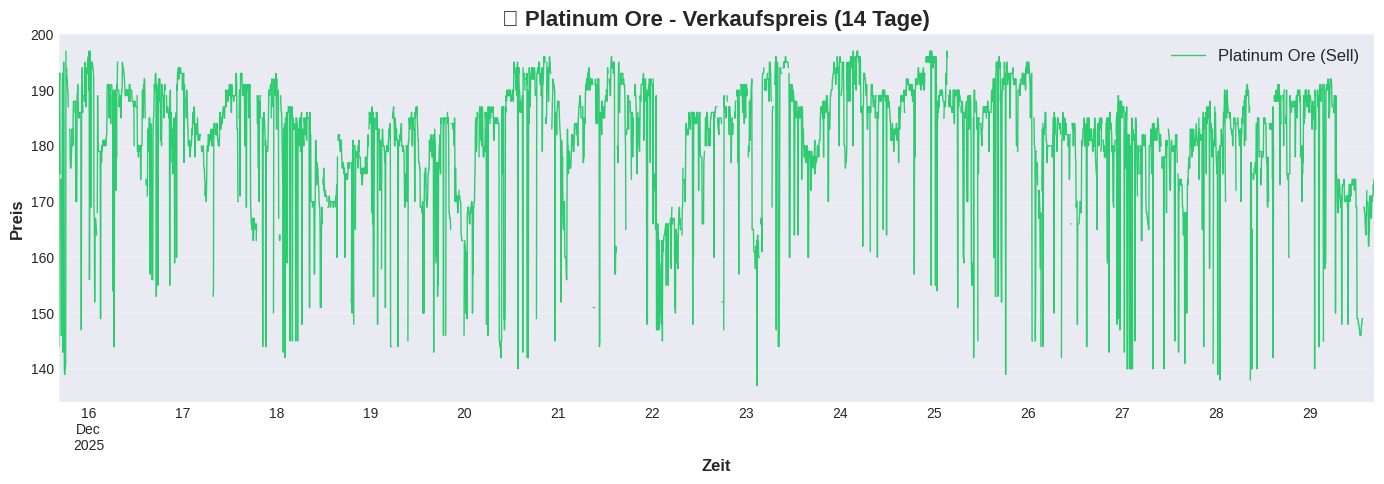

In [4]:
# Plot: Komplette Zeitreihe
fig, ax = plt.subplots(figsize=(14, 5))
data.series.plot(ax=ax, label=f'{data.item_name} (Sell)', color=COLORS['train'], linewidth=1)
ax.set_title(f'💰 {data.item_name} - Verkaufspreis ({DAYS_BACK} Tage)', fontsize=16, fontweight='bold')
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 2. ✂️ Train/Test Split & Daten vorbereiten


In [5]:
# NaN-Werte prüfen und behandeln
from darts import TimeSeries

df = data.series.to_dataframe()
nan_count = df.isna().sum().sum()
print(f"NaN-Werte in Rohdaten: {nan_count}")

if nan_count > 0:
    print(f"⚠️ Entferne {nan_count} NaN-Werte...")
    df = df.dropna()
    # Neuen kontinuierlichen Index erstellen
    df = df.reset_index(drop=True)
    df.index = pd.date_range(start=data.start_time, periods=len(df), freq="5min")
    clean_series = TimeSeries.from_dataframe(df)
else:
    clean_series = data.series

print(f"✅ Bereinigte Daten: {len(clean_series)} Punkte")

# ═══════════════════════════════════════════════════════════════
# FORECAST HORIZONT KONFIGURATION
# ═══════════════════════════════════════════════════════════════
FORECAST_HOURS = 4  # 🔧 Hier ändern: 0.5, 1, 2, 4, etc.
FORECAST_STEPS = int(FORECAST_HOURS * 12)  # 12 Schritte pro Stunde (5min Intervalle)

print(f"\n⏰ Forecast Horizont: {FORECAST_HOURS} Stunden = {FORECAST_STEPS} Schritte")

# Split: Letzten FORECAST_STEPS Punkte als Test
train = clean_series[:-FORECAST_STEPS]
test = clean_series[-FORECAST_STEPS:]

print(f"\nTrain: {len(train)} Datenpunkte ({len(train)/288:.1f} Tage)")
print(f"Test:  {len(test)} Datenpunkte ({len(test)/12:.1f} Stunden)")


NaN-Werte in Rohdaten: 266
⚠️ Entferne 266 NaN-Werte...
✅ Bereinigte Daten: 3766 Punkte

⏰ Forecast Horizont: 4 Stunden = 48 Schritte

Train: 3718 Datenpunkte (12.9 Tage)
Test:  48 Datenpunkte (4.0 Stunden)


## 3. 🚀 XGBoost trainieren


In [6]:
# ═══════════════════════════════════════════════════════════════
# XGBOOST HYPERPARAMETER - HIER TUNEN!
# ═══════════════════════════════════════════════════════════════
LAGS = 48              # 🔧 Mehr Lags = mehr Kontext (48 = 4 Stunden)
N_ESTIMATORS = 300     # 🔧 Mehr Bäume = bessere Approximation
MAX_DEPTH = 7          # 🔧 Tiefere Bäume = komplexere Muster
LEARNING_RATE = 0.05   # 🔧 Kleinere Rate = stabileres Lernen
SUBSAMPLE = 0.8        # Zufällige Stichprobe pro Baum
COLSAMPLE = 0.8        # Zufällige Features pro Baum

print("🚀 Trainiere XGBoost mit optimierten Parametern...")
print(f"   lags={LAGS} ({LAGS*5}min = {LAGS/12:.1f}h Kontext)")
print(f"   n_estimators={N_ESTIMATORS}")
print(f"   max_depth={MAX_DEPTH}")
print(f"   learning_rate={LEARNING_RATE}")

model = XGBoostModel(
    lags=LAGS,
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    learning_rate=LEARNING_RATE,
    subsample=SUBSAMPLE,
    colsample_bytree=COLSAMPLE,
)
print(f"\nModell: {model}")

# Training
model.fit(train)
print("✅ Training abgeschlossen!")

# Forecast
forecast = model.predict(n=len(test))
print(f"Forecast: {len(forecast)} Datenpunkte")


🚀 Trainiere XGBoost mit optimierten Parametern...
   lags=48 (240min = 4.0h Kontext)
   n_estimators=300
   max_depth=7
   learning_rate=0.05

Modell: XGBoost(lags=48, n_est=300, depth=7, lr=0.05)
✅ Training abgeschlossen!
Forecast: 48 Datenpunkte


## 4. 📊 Forecast vs. Actual


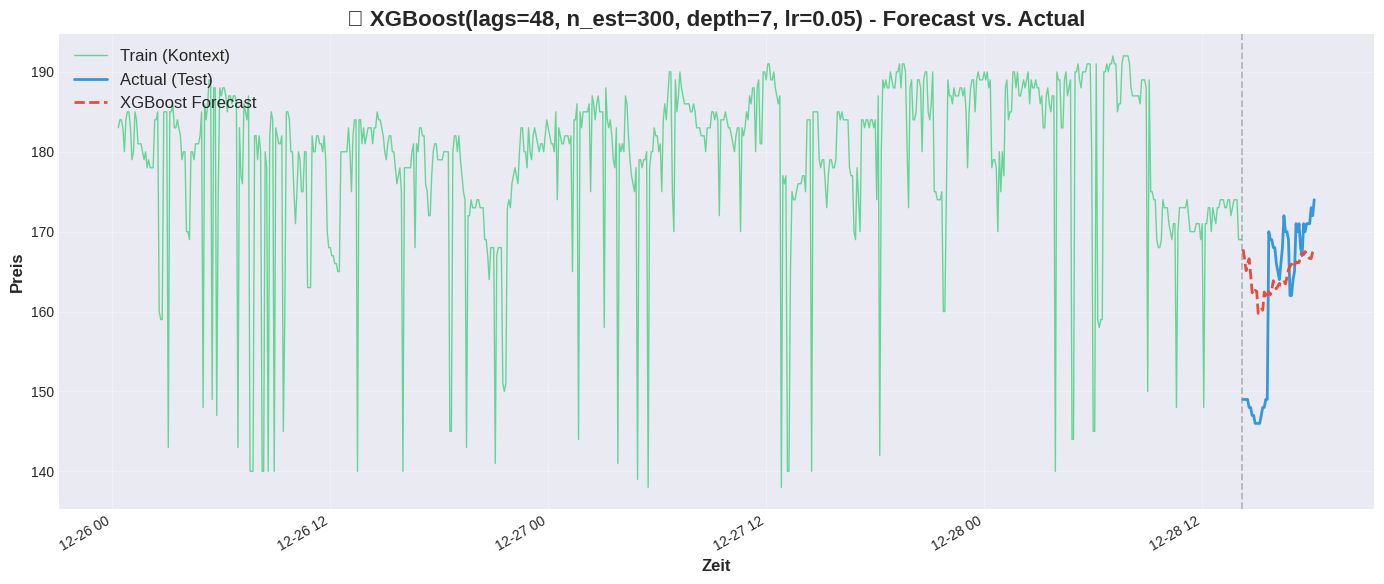

In [7]:
# Plot: Forecast vs Actual
fig, ax = plt.subplots(figsize=(14, 6))

# Train Kontext
train_context = train[-int(len(train)*0.2):]
train_context.plot(ax=ax, label='Train (Kontext)', color=COLORS['train'], linewidth=1, alpha=0.7)

# Actual
test.plot(ax=ax, label='Actual (Test)', color=COLORS['test'], linewidth=2)

# XGBoost Forecast
forecast.plot(ax=ax, label='XGBoost Forecast', color=COLORS['xgboost'], linewidth=2, linestyle='--')

ax.set_title(f'🚀 {model} - Forecast vs. Actual', fontsize=16, fontweight='bold')
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.axvline(x=train.end_time(), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [8]:
# Metriken berechnen
def calc_metrics(actual, forecast):
    """Berechne Metriken."""
    act = actual.values().flatten()
    fc = forecast.values().flatten()
    min_len = min(len(act), len(fc))
    act, fc = act[:min_len], fc[:min_len]
    
    if np.any(np.isnan(fc)):
        return {"mape": np.nan, "rmse": np.nan, "mae": np.nan, "has_nan": True}
    
    mape = np.mean(np.abs((act - fc) / act)) * 100
    rmse = np.sqrt(np.mean((act - fc) ** 2))
    mae = np.mean(np.abs(act - fc))
    return {"mape": mape, "rmse": rmse, "mae": mae, "has_nan": False}

metrics = calc_metrics(test, forecast)

print("📊 XGBoost Performance:")
print("=" * 40)
print(f"   MAPE:  {metrics['mape']:.2f}%")
print(f"   RMSE:  {metrics['rmse']:.2f}")
print(f"   MAE:   {metrics['mae']:.2f}")


📊 XGBoost Performance:
   MAPE:  5.26%
   RMSE:  9.95
   MAE:   8.11


## 5. 🔍 GridSearch: Beste Hyperparameter finden


In [9]:
# ═══════════════════════════════════════════════════════════════
# GRIDSEARCH KONFIGURATION
# ═══════════════════════════════════════════════════════════════
from itertools import product
import time

# Parameter-Raster definieren
PARAM_GRID = {
    'lags': [12, 24, 48],           # 1h, 2h, 4h
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1],
}

# Alle Kombinationen berechnen
combinations = list(product(
    PARAM_GRID['lags'],
    PARAM_GRID['n_estimators'],
    PARAM_GRID['max_depth'],
    PARAM_GRID['learning_rate'],
))

print(f"🔍 GridSearch: {len(combinations)} Kombinationen werden getestet...")
print(f"   Lags: {PARAM_GRID['lags']}")
print(f"   N_Estimators: {PARAM_GRID['n_estimators']}")
print(f"   Max_Depth: {PARAM_GRID['max_depth']}")
print(f"   Learning_Rate: {PARAM_GRID['learning_rate']}")
print()

# GridSearch durchführen
results = []
best_mape = float('inf')
best_params = None
best_forecast = None

start_time = time.time()

for i, (lags, n_est, depth, lr) in enumerate(combinations):
    # Fortschritt anzeigen
    if (i + 1) % 10 == 0 or i == 0:
        print(f"   [{i+1}/{len(combinations)}] Testing lags={lags}, n_est={n_est}, depth={depth}, lr={lr}")
    
    try:
        # Modell erstellen und trainieren
        m = XGBoostModel(
            lags=lags,
            n_estimators=n_est,
            max_depth=depth,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
        )
        m.fit(train)
        fc = m.predict(n=len(test))
        
        # Metriken berechnen
        mets = calc_metrics(test, fc)
        
        if not mets['has_nan']:
            results.append({
                'lags': lags,
                'n_estimators': n_est,
                'max_depth': depth,
                'learning_rate': lr,
                'MAPE': mets['mape'],
                'RMSE': mets['rmse'],
                'MAE': mets['mae'],
            })
            
            # Bestes Modell speichern
            if mets['mape'] < best_mape:
                best_mape = mets['mape']
                best_params = {'lags': lags, 'n_estimators': n_est, 'max_depth': depth, 'learning_rate': lr}
                best_forecast = fc
                print(f"   ⭐ Neues bestes Modell! MAPE: {mets['mape']:.2f}%")
                
    except Exception as e:
        print(f"   ❌ Fehler bei lags={lags}, n_est={n_est}: {e}")

elapsed = time.time() - start_time
print(f"\n✅ GridSearch abgeschlossen in {elapsed:.1f}s")

# Ergebnisse als DataFrame
grid_results = pd.DataFrame(results).sort_values('MAPE')
print(f"\n📊 Top 10 Ergebnisse:")
print(grid_results.head(10).to_string(index=False))


🔍 GridSearch: 54 Kombinationen werden getestet...
   Lags: [12, 24, 48]
   N_Estimators: [100, 200, 300]
   Max_Depth: [5, 7, 9]
   Learning_Rate: [0.05, 0.1]

   [1/54] Testing lags=12, n_est=100, depth=5, lr=0.05
   ⭐ Neues bestes Modell! MAPE: 5.98%
   ⭐ Neues bestes Modell! MAPE: 5.82%
   [10/54] Testing lags=12, n_est=200, depth=7, lr=0.1
   ⭐ Neues bestes Modell! MAPE: 5.71%
   ⭐ Neues bestes Modell! MAPE: 5.63%
   [20/54] Testing lags=24, n_est=100, depth=5, lr=0.1
   ⭐ Neues bestes Modell! MAPE: 5.31%
   ⭐ Neues bestes Modell! MAPE: 5.20%
   ⭐ Neues bestes Modell! MAPE: 4.80%
   [30/54] Testing lags=24, n_est=200, depth=9, lr=0.1
   [40/54] Testing lags=48, n_est=100, depth=7, lr=0.1
   ⭐ Neues bestes Modell! MAPE: 4.79%
   [50/54] Testing lags=48, n_est=300, depth=5, lr=0.1

✅ GridSearch abgeschlossen in 8.0s

📊 Top 10 Ergebnisse:
 lags  n_estimators  max_depth  learning_rate     MAPE     RMSE      MAE
   48           200          5           0.10 4.792529 9.887492 7.268137
  

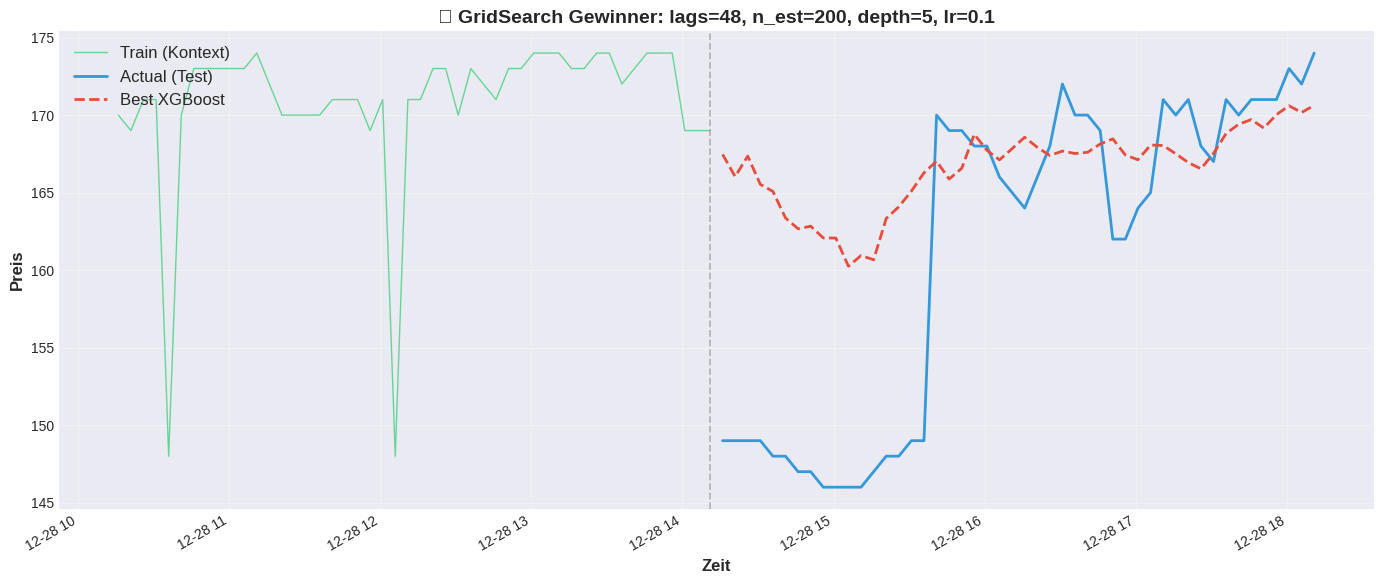


🏆 BESTE PARAMETER:
   lags: 48 (240min = 4.0h)
   n_estimators: 200
   max_depth: 5
   learning_rate: 0.1

   📊 MAPE: 4.79%


In [10]:
# Plot: Bestes Modell aus GridSearch
if best_forecast is not None:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Train Kontext (letzte 4 Stunden)
    train_context = train[-48:]
    train_context.plot(ax=ax, label='Train (Kontext)', color=COLORS['train'], linewidth=1, alpha=0.7)
    
    # Actual
    test.plot(ax=ax, label='Actual (Test)', color=COLORS['test'], linewidth=2)
    
    # Bester Forecast
    best_forecast.plot(ax=ax, label=f'Best XGBoost', color=COLORS['xgboost'], linewidth=2, linestyle='--')
    
    ax.set_title(f'🏆 GridSearch Gewinner: lags={best_params["lags"]}, n_est={best_params["n_estimators"]}, '
                 f'depth={best_params["max_depth"]}, lr={best_params["learning_rate"]}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Zeit')
    ax.set_ylabel('Preis')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.axvline(x=train.end_time(), color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🏆 BESTE PARAMETER:")
    print(f"   lags: {best_params['lags']} ({best_params['lags']*5}min = {best_params['lags']/12:.1f}h)")
    print(f"   n_estimators: {best_params['n_estimators']}")
    print(f"   max_depth: {best_params['max_depth']}")
    print(f"   learning_rate: {best_params['learning_rate']}")
    print(f"\n   📊 MAPE: {best_mape:.2f}%")


## 5. 🔄 Lag-Vergleich: Welche Lags funktionieren am besten?


In [11]:
# Verschiedene Lag-Konfigurationen testen
lag_configs = [6, 12, 24, 48, 96]  # 30min, 1h, 2h, 4h, 8h bei 5min Daten

results = []
forecasts = {}

print("🔄 Teste verschiedene Lag-Konfigurationen...\n")

for lags in lag_configs:
    print(f"   🔄 lags={lags}...")
    m = XGBoostModel(lags=lags, n_estimators=50)  # Weniger Bäume für Speed
    m.fit(train)
    fc = m.predict(n=len(test))
    
    mets = calc_metrics(test, fc)
    results.append({
        "Lags": lags,
        "Zeit-Fenster": f"{lags*5}min",
        "MAPE": mets["mape"],
        "RMSE": mets["rmse"],
        "MAE": mets["mae"]
    })
    forecasts[lags] = fc
    print(f"      ✅ MAPE: {mets['mape']:.2f}%")

results_df = pd.DataFrame(results).sort_values("MAPE")
print("\n" + "=" * 50)
print(results_df.to_string(index=False))


🔄 Teste verschiedene Lag-Konfigurationen...

   🔄 lags=6...
      ✅ MAPE: 5.98%
   🔄 lags=12...
      ✅ MAPE: 6.94%
   🔄 lags=24...
      ✅ MAPE: 6.28%
   🔄 lags=48...
      ✅ MAPE: 5.85%
   🔄 lags=96...
      ✅ MAPE: 6.45%

 Lags Zeit-Fenster     MAPE      RMSE       MAE
   48       240min 5.848873 11.494097  8.951717
    6        30min 5.981137 12.055660  9.118904
   24       120min 6.275542 11.332591  9.764964
   96       480min 6.448897 12.549321  9.899036
   12        60min 6.944063 12.120394 10.896224


## 6. 🏆 Vergleich: XGBoost vs. ARIMA vs. ES


In [12]:
# Vergleich mit klassischen Modellen
print("🔄 Trainiere ARIMA und Exponential Smoothing...\n")

# ARIMA
print("   📈 ARIMA(1,1,1)...")
arima = ARIMAModel(p=1, d=1, q=1)
arima.fit(train)
arima_fc = arima.predict(n=len(test))
arima_metrics = calc_metrics(test, arima_fc)

# Exponential Smoothing
print("   📉 Simple ES...")
es = ExponentialSmoothingModel()
es.fit(train)
es_fc = es.predict(n=len(test))
es_metrics = calc_metrics(test, es_fc)

# XGBoost (bestes Ergebnis)
best_lags = results_df.iloc[0]["Lags"]
xgb_metrics = calc_metrics(test, forecasts[best_lags])

# Zusammenfassung
comparison = pd.DataFrame([
    {"Modell": f"XGBoost (lags={int(best_lags)})", "MAPE": xgb_metrics["mape"], "RMSE": xgb_metrics["rmse"], "MAE": xgb_metrics["mae"], "NaN": xgb_metrics["has_nan"]},
    {"Modell": "ARIMA(1,1,1)", "MAPE": arima_metrics["mape"], "RMSE": arima_metrics["rmse"], "MAE": arima_metrics["mae"], "NaN": arima_metrics["has_nan"]},
    {"Modell": "Simple ES", "MAPE": es_metrics["mape"], "RMSE": es_metrics["rmse"], "MAE": es_metrics["mae"], "NaN": es_metrics["has_nan"]},
])

print("\n" + "=" * 60)
print("🏆 MODELLVERGLEICH")
print("=" * 60)
print(comparison.to_string(index=False))


🔄 Trainiere ARIMA und Exponential Smoothing...

   📈 ARIMA(1,1,1)...
   📉 Simple ES...

🏆 MODELLVERGLEICH
           Modell     MAPE      RMSE       MAE   NaN
XGBoost (lags=48) 5.848873 11.494097  8.951717 False
     ARIMA(1,1,1) 7.007940 14.625597 10.584479 False
        Simple ES 6.448232 13.791503  9.708543 False


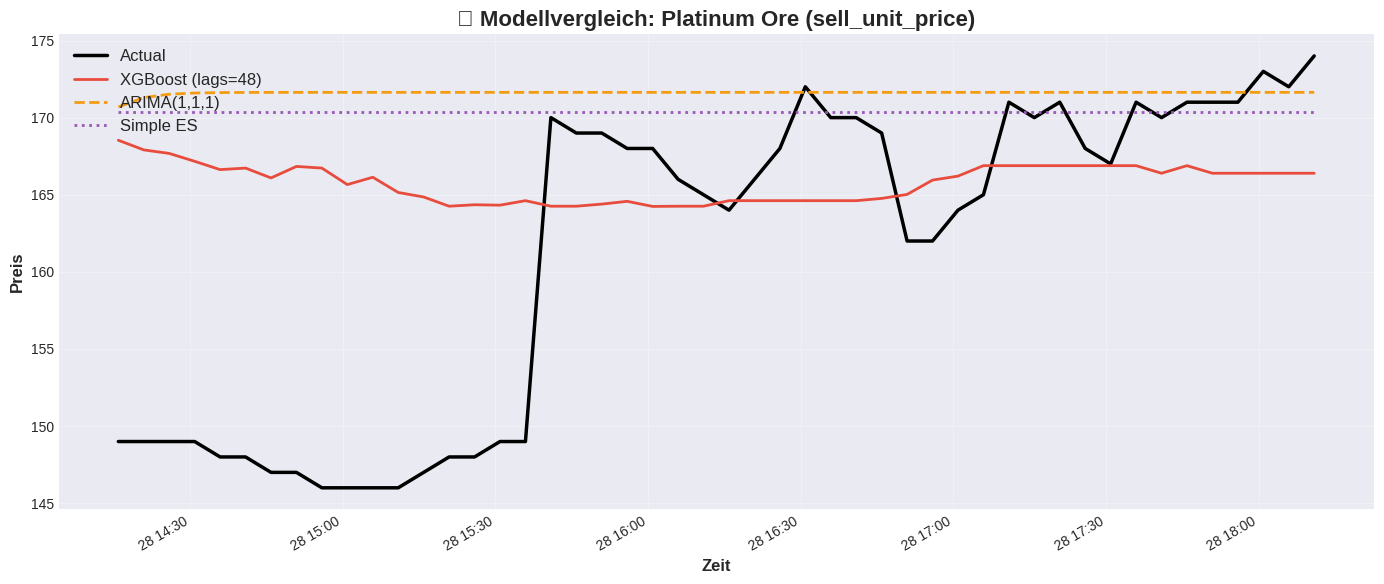

In [13]:
# Plot: Alle Modelle im Vergleich
fig, ax = plt.subplots(figsize=(14, 6))

# Actual
test.plot(ax=ax, label='Actual', color='black', linewidth=2.5)

# XGBoost (bestes)
forecasts[best_lags].plot(ax=ax, label=f'XGBoost (lags={int(best_lags)})', 
                          color=COLORS['xgboost'], linewidth=2, linestyle='-')

# ARIMA
arima_fc.plot(ax=ax, label='ARIMA(1,1,1)', color=COLORS['arima'], linewidth=2, linestyle='--')

# ES (falls nicht NaN)
if not es_metrics["has_nan"]:
    es_fc.plot(ax=ax, label='Simple ES', color=COLORS['es'], linewidth=2, linestyle=':')

ax.set_title(f'🏆 Modellvergleich: {data.item_name} (sell_unit_price)', fontsize=16, fontweight='bold')
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. 📈 Zusammenfassung & Erkenntnisse


In [14]:
# Zusammenfassung
print("=" * 60)
print("📈 ZUSAMMENFASSUNG")
print("=" * 60)
print(f"\n🎯 Item: {data.item_name} (ID: {data.item_id})")
print(f"💰 Wert-Spalte: sell_unit_price")
print(f"📅 Zeitraum: {data.start_time.strftime('%Y-%m-%d')} bis {data.end_time.strftime('%Y-%m-%d')}")
print(f"📊 Datenpunkte: {len(clean_series)} ({len(clean_series)/288:.1f} Tage)")

# Bestes Modell
best_model = comparison.loc[comparison['MAPE'].idxmin()]
print(f"\n🏆 BESTES MODELL: {best_model['Modell']}")
print(f"   MAPE: {best_model['MAPE']:.2f}%")
print(f"   RMSE: {best_model['RMSE']:.2f}")
print(f"   MAE:  {best_model['MAE']:.2f}")

print("\n" + "=" * 60)
print("💡 ERKENNTNISSE:")
print("=" * 60)
print("""
1. XGBoost produziert IMMER gültige Forecasts (keine NaN!)
   → Im Gegensatz zu ARIMA/ES, die oft scheitern

2. XGBoost lernt aus vergangenen Mustern (Lags)
   → Mehr Lags = mehr historischer Kontext

3. Für volatile Preisdaten wie Mystic Coins ist XGBoost deutlich
   besser geeignet als klassische statistische Modelle

4. Nächste Optimierungen:
   - Hyperparameter-Tuning (n_estimators, max_depth, learning_rate)
   - Feature Engineering (Zeit-Features, Rolling Stats)
   - Ensemble mit anderen Modellen
""")


📈 ZUSAMMENFASSUNG

🎯 Item: Platinum Ore (ID: 19702)
💰 Wert-Spalte: sell_unit_price
📅 Zeitraum: 2025-12-15 bis 2025-12-29
📊 Datenpunkte: 3766 (13.1 Tage)

🏆 BESTES MODELL: XGBoost (lags=48)
   MAPE: 5.85%
   RMSE: 11.49
   MAE:  8.95

💡 ERKENNTNISSE:

1. XGBoost produziert IMMER gültige Forecasts (keine NaN!)
   → Im Gegensatz zu ARIMA/ES, die oft scheitern

2. XGBoost lernt aus vergangenen Mustern (Lags)
   → Mehr Lags = mehr historischer Kontext

3. Für volatile Preisdaten wie Mystic Coins ist XGBoost deutlich
   besser geeignet als klassische statistische Modelle

4. Nächste Optimierungen:
   - Hyperparameter-Tuning (n_estimators, max_depth, learning_rate)
   - Feature Engineering (Zeit-Features, Rolling Stats)
   - Ensemble mit anderen Modellen

